In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/My Drive/DATASET_roboflow"

GlaciArc.v2i.png-mask-semantic.zip  Masks  Original


In [ ]:
import os
import numpy as np
from PIL import Image, ImageEnhance
import random
import gc
import matplotlib.pyplot as plt

# Define the color map for each class
color_map = {
    0: (255, 255, 0),  # Background
    1: (199, 252, 0),  # Glacier
    2: (254, 0, 86),   # House_Building
    3: (0, 183, 235),  # Ice
    4: (134, 34, 255), # Land
    5: (255, 255, 0),  # Undefined
    6: (0, 255, 206),  # Vegetation
    7: (255, 128, 0),  # Water
}

# Normalize image by scaling the pixel values to [0, 1]
def normalize_image(image):
    return image.astype(np.float32) / 255.0

# One-hot encoding for the mask
def one_hot_encode_mask(mask, num_classes=8):
    one_hot = np.zeros((mask.shape[0], mask.shape[1], num_classes), dtype=np.float32)
    for class_value in range(num_classes):
        one_hot[mask == class_value, class_value] = 1
    return one_hot

# Function to check if dimensions are divisible by patch_size, and crop if needed
def make_divisible(image, patch_size):
    height, width = image.shape[:2]
    new_height = (height // patch_size) * patch_size
    new_width = (width // patch_size) * patch_size
    return image[:new_height, :new_width]

# Function to create patches from an image
def create_patches(image, patch_size):
    patches = []
    height, width = image.shape[:2]
    for i in range(0, height, patch_size):
        for j in range(0, width, patch_size):
            patch = image[i:i + patch_size, j:j + patch_size]
            if patch.shape[:2] == (patch_size, patch_size):
                patches.append(patch)
    return np.array(patches)

# Augmentation Functions
def random_horizontal_flip(image, mask, probability=0.5):
    if random.random() < probability:
        image = np.fliplr(image)
        mask = np.fliplr(mask)
    return image, mask

def random_vertical_flip(image, mask, probability=0.5):
    if random.random() < probability:
        image = np.flipud(image)
        mask = np.flipud(mask)
    return image, mask

def random_rotate(image, mask, angle_range=(-30, 30)):
    angle = random.uniform(angle_range[0], angle_range[1])
    image = Image.fromarray((image * 255).astype(np.uint8))
    mask = Image.fromarray(np.argmax(mask, axis=-1).astype(np.uint8))
    image = image.rotate(angle, resample=Image.BICUBIC, expand=False)
    mask = mask.rotate(angle, resample=Image.NEAREST, expand=False)
    image = np.array(image) / 255.0
    mask = np.array(mask)
    mask = one_hot_encode_mask(mask, num_classes=8)
    return image, mask

def random_brightness_contrast(image, brightness_factor=0.2, contrast_factor=0.2):
    enhancer = ImageEnhance.Brightness(Image.fromarray((image * 255).astype(np.uint8)))
    image = enhancer.enhance(1 + random.uniform(-brightness_factor, brightness_factor))
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(1 + random.uniform(-contrast_factor, contrast_factor))
    return np.array(image) / 255.0

def apply_augmentation(image, mask):
    image, mask = random_horizontal_flip(image, mask)
    image, mask = random_vertical_flip(image, mask)
    image, mask = random_rotate(image, mask)
    image = random_brightness_contrast(image)
    return image, mask


Processing image Passu_2019_July_1_jpg.rf.25988459bf8a6ebaa9ccd6c7240ed7ff.jpg and mask Passu_2019_July_1_jpg.rf.25988459bf8a6ebaa9ccd6c7240ed7ff_mask.png...
Created 10 patches from Passu_2019_July_1_jpg.rf.25988459bf8a6ebaa9ccd6c7240ed7ff.jpg and Passu_2019_July_1_jpg.rf.25988459bf8a6ebaa9ccd6c7240ed7ff_mask.png...
Processing image Passu_2019_July_2_jpg.rf.212bdd55c48b6fdb6eeda8e743bffa13.jpg and mask Passu_2019_July_2_jpg.rf.212bdd55c48b6fdb6eeda8e743bffa13_mask.png...
Created 12 patches from Passu_2019_July_2_jpg.rf.212bdd55c48b6fdb6eeda8e743bffa13.jpg and Passu_2019_July_2_jpg.rf.212bdd55c48b6fdb6eeda8e743bffa13_mask.png...
Processing image Passu_2019_July_3_jpg.rf.e7e603acbce988a695e721891b407b38.jpg and mask Passu_2019_July_3_jpg.rf.e7e603acbce988a695e721891b407b38_mask.png...
Created 4 patches from Passu_2019_July_3_jpg.rf.e7e603acbce988a695e721891b407b38.jpg and Passu_2019_July_3_jpg.rf.e7e603acbce988a695e721891b407b38_mask.png...
Processing image Passu_2019_July_4_jpg.rf.89206

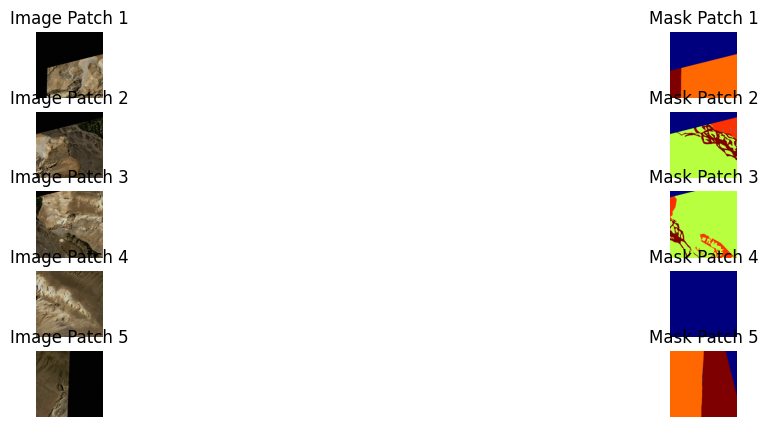

In [ ]:
def process_all_images(image_folder, mask_folder, patch_size):
    image_files = sorted(os.listdir(image_folder))
    mask_files = sorted(os.listdir(mask_folder))

    all_image_patches = []
    all_mask_patches = []

    for idx, image_file in enumerate(image_files[:37]):
        mask_file = mask_files[idx]

        print(f"Processing image {image_file} and mask {mask_file}...")

        image = np.array(Image.open(os.path.join(image_folder, image_file)).convert("RGB"))
        mask = np.array(Image.open(os.path.join(mask_folder, mask_file)).convert("L"))

        image = normalize_image(image)
        mask = one_hot_encode_mask(mask, num_classes=8)

        # Ensure consistent dimensions before patching
        image, mask = make_divisible(image, patch_size), make_divisible(mask, patch_size)

        image, mask = apply_augmentation(image, mask)

        image_patches = create_patches(image, patch_size)
        mask_patches = create_patches(mask, patch_size)

        # Check if the number of patches is the same for both images and masks
        if len(image_patches) != len(mask_patches):
            print(f"Warning: Inconsistent number of patches for image {image_file} and mask {mask_file}")
            # If there is a mismatch in the number of patches use the smaller one
            min_num_patches = min(len(image_patches), len(mask_patches))
            image_patches = image_patches[:min_num_patches]
            mask_patches = mask_patches[:min_num_patches]

        all_image_patches.extend(image_patches)
        all_mask_patches.extend(mask_patches)

        print(f"Created {len(image_patches)} patches from {image_file} and {mask_file}...")
    return np.array(all_image_patches), np.array(all_mask_patches)

patch_size = 256
image_folder = '/content/drive/My Drive//DATASET_roboflow/Original'
mask_folder = '/content/drive/My Drive/DATASET_roboflow/Masks'

all_image_patches, all_mask_patches = process_all_images(image_folder, mask_folder, patch_size)

# Visualize patches
def visualize_patches(image_patches, mask_patches, color_map, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(image_patches[i])
        plt.title(f'Image Patch {i+1}')
        plt.axis('off')

        plt.subplot(num_samples, 2, 2 * i + 2)
        mask = np.argmax(mask_patches[i], axis=-1)
        plt.imshow(mask, cmap='jet')
        plt.title(f'Mask Patch {i+1}')
        plt.axis('off')
    plt.show()

visualize_patches(all_image_patches, all_mask_patches, color_map, num_samples=5)


In [ ]:
from sklearn.model_selection import train_test_split

train_images, val_images, train_masks, val_masks = train_test_split(
    all_image_patches, all_mask_patches, test_size=0.2, random_state=42
)

print(f"Training images shape: {train_images.shape}")
print(f"Validation images shape: {val_images.shape}")
print(f"Training masks shape: {train_masks.shape}")
print(f"Validation masks shape: {val_masks.shape}")


Training images shape: (393, 256, 256, 3)
Validation images shape: (99, 256, 256, 3)
Training masks shape: (393, 256, 256, 8)
Validation masks shape: (99, 256, 256, 8)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class SegmentationDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        return torch.tensor(image, dtype=torch.float32).permute(2, 0, 1), torch.tensor(mask, dtype=torch.float32).permute(2, 0, 1)

train_dataset = SegmentationDataset(train_images, train_masks)
val_dataset = SegmentationDataset(val_images, val_masks)

batch_size = 3
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
pip install segmentation_models_pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp
import torch

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the U-Net model with ResNet50 as the backbone
model = smp.Unet(
    encoder_name="resnet50",        # Use ResNet50 as the backbone
    encoder_weights="imagenet",    # Pretrained on ImageNet
    in_channels=3,                 # Input channels (e.g., RGB)
    classes=8,                     # Number of segmentation classes
    decoder_use_batchnorm=True     # Use batch normalization in the decoder
).to(device)

# Add dropout layers manually by modifying the decoder blocks
for block in model.decoder.blocks:
    # Extract existing layers of the block
    existing_layers = list(block.children())

    # Add a Dropout layer with 50% probability
    dropout_layer = nn.Dropout(p=0.5)

    # Reconstruct the block with the existing layers + dropout
    new_block = nn.Sequential(*existing_layers, dropout_layer)

    # Replace the original block with the modified block
    block = new_block



# Count occurrences of each class in the training dataset
num_classes = 8  # Total classes
class_counts = np.zeros(num_classes)

# Flatten the one-hot encoded masks and count occurrences
for mask in train_masks:
    class_ids, counts = np.unique(np.argmax(mask, axis=-1), return_counts=True)
    for cid, count in zip(class_ids, counts):
        class_counts[cid] += count

# Compute inverse frequency weights (higher weight for small classes)
class_weights = 1.0 / (class_counts + 1e-6)  # Avoid division by zero
class_weights /= class_weights.sum()  # Normalize weights

# Convert to tensor for PyTorch
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

print("Class Weights:", class_weights)


# Define the loss function
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Add a learning rate scheduler to adjust learning rate during training
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",        # Minimize validation loss
    patience=3,        # Reduce learning rate after 3 epochs with no improvement
    factor=0.5,        # Reduce learning rate by a factor of 0.5
    verbose=True       # Print adjustments to the learning rate
)

# Display the model architecture
print(model)


Class Weights: [5.67787805e-04 1.10499481e-03 9.83872436e-01 1.34333366e-03
 1.71782226e-04 2.35774681e-03 6.52366166e-03 4.05825709e-03]
Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, e

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
from tqdm import tqdm

# Function to calculate accuracy
def calculate_accuracy(preds, labels):
    # Compute accuracy by comparing predicted and ground truth masks
    preds = torch.argmax(preds, dim=1)  # Get predicted class
    correct = (preds == labels).float()  # Compare with ground truth
    return correct.sum() / correct.numel()

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt

# Function to calculate accuracy
def calculate_accuracy(preds, labels):
    # Compute accuracy by comparing predicted and ground truth masks
    preds = torch.argmax(preds, dim=1)  # Get predicted class
    correct = (preds == labels).float()  # Compare with ground truth
    return correct.sum() / correct.numel()

# Function to visualize predictions
def visualize_predictions(images, ground_truth_masks, predicted_masks, color_map, num_samples=5):
    # Determine the actual number of samples available
    actual_samples = min(num_samples, len(images))

    for i in range(actual_samples):
        image = images[i].cpu().numpy().transpose(1, 2, 0)
        true_mask = ground_truth_masks[i].cpu().numpy()
        pred_mask = predicted_masks[i]  # Already converted to numpy in training loop

        # Convert masks to colorized versions
        true_mask_colored = apply_color_map(true_mask, color_map)
        pred_mask_colored = apply_color_map(pred_mask, color_map)

        # Plot image, ground truth, and predicted mask
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(image)
        axes[0].set_title("Input Image")
        axes[0].axis("off")

        axes[1].imshow(true_mask_colored)
        axes[1].set_title("Ground Truth Mask")
        axes[1].axis("off")

        axes[2].imshow(pred_mask_colored)
        axes[2].set_title("Predicted Mask")
        axes[2].axis("off")

        plt.show()

# Function to apply color mapping
def apply_color_map(mask, color_map):
    # Map each class in the mask to its corresponding color
    height, width = mask.shape
    rgb_mask = np.zeros((height, width, 3), dtype=np.uint8)
    for class_id, color in color_map.items():
        rgb_mask[mask == class_id] = color
    return rgb_mask

# Function to train the model
def train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler,
    num_epochs, checkpoint_path, visualize_on="val", num_visualize=5, color_map=None
):
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        # Training phase
        model.train()
        train_loss, train_acc = 0.0, 0.0

        for images, masks in tqdm(train_loader, desc="Training"):
            images = images.to(device)
            masks = masks.argmax(dim=1).to(device)  # Convert one-hot to class labels

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += calculate_accuracy(outputs, masks).item()

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        print(f"Training Loss: {train_loss:.4f} | Training Accuracy: {train_acc:.4f}")

        # Validation phase
        model.eval()
        val_loss, val_acc = 0.0, 0.0

        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc="Validation"):
                images = images.to(device)
                masks = masks.argmax(dim=1).to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)

                val_loss += loss.item()
                val_acc += calculate_accuracy(outputs, masks).item()

        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f}")

        # Adjust learning rate if validation loss plateaus
        scheduler.step(val_loss)

        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            print("Saving checkpoint...")
            torch.save(model.state_dict(), checkpoint_path)

        # Visualize predictions after each epoch (optional)
        if visualize_on == "val" and epoch % 1 == 0:
            num_available_samples = min(num_visualize, len(images))
            visualize_predictions(
                images[:num_available_samples],
                masks[:num_available_samples],
                torch.argmax(outputs[:num_available_samples], dim=1).cpu().numpy(),
                color_map=color_map
            )

    print("Training complete!")

In [ ]:

def calculate_iou(preds, labels, num_classes=8):
    '''
    Calculate Intersection over Union (IoU) for semantic segmentation.

    Args:
    preds: Predicted masks (N, H, W) after argmax.
    labels: Ground truth masks (N, H, W).
    num_classes: Number of classes.

    Returns:
    Mean IoU across all classes.
    '''
    iou_scores = []
    for class_id in range(num_classes):
        intersection = ((preds == class_id) & (labels == class_id)).sum().item()
        union = ((preds == class_id) | (labels == class_id)).sum().item()
        if union > 0:
            iou_scores.append(intersection / union)
    return np.nanmean(iou_scores)


In [ ]:
def calculate_metrics(preds, labels, num_classes=8):
    '''
    Calculate IoU, Precision, Recall, F1 Score, and Dice Coefficient for semantic segmentation.

    Args:
    preds: Predicted masks (N, H, W) after argmax.
    labels: Ground truth masks (N, H, W).
    num_classes: Number of classes.

    Returns:
    Metrics as a dictionary containing IoU, Precision, Recall, F1, and Dice Coefficient.
    '''
    metrics = {'IoU': [], 'Precision': [], 'Recall': [], 'F1': [], 'Dice': []}

    for class_id in range(num_classes):
        intersection = ((preds == class_id) & (labels == class_id)).sum().item()
        pred_positive = (preds == class_id).sum().item()
        label_positive = (labels == class_id).sum().item()
        union = ((preds == class_id) | (labels == class_id)).sum().item()

        precision = intersection / pred_positive if pred_positive > 0 else 0
        recall = intersection / label_positive if label_positive > 0 else 0
        iou = intersection / union if union > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        dice = 2 * intersection / (2 * intersection + union - intersection) if union > 0 else 0

        metrics['IoU'].append(iou)
        metrics['Precision'].append(precision)
        metrics['Recall'].append(recall)
        metrics['F1'].append(f1)
        metrics['Dice'].append(dice)

    # Mean of each metric across all classes
    return {key: np.nanmean(value) for key, value in metrics.items()}


In [ ]:
import torch

def train_model_with_metrics(
    model, train_loader, val_loader, criterion, optimizer, scheduler,
    num_epochs, checkpoint_path, visualize_on="val", num_visualize=5, color_map=None, num_classes=8
):
    best_val_loss = float('inf')
    best_val_acc = 0.0  # Track the best validation accuracy

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        # Training phase
        model.train()
        train_loss, train_acc = 0.0, 0.0

        for images, masks in tqdm(train_loader, desc="Training"):
            images = images.to(device)
            masks = masks.argmax(dim=1).to(device)  # Convert one-hot to class labels

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += calculate_accuracy(outputs, masks).item()

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        print(f"Training Loss: {train_loss:.4f} | Training Accuracy: {train_acc:.4f}")

        # Validation phase
        model.eval()
        val_loss, val_acc = 0.0, 0.0
        val_metrics = {'IoU': 0.0, 'Precision': 0.0, 'F1': 0.0, 'Dice': 0.0}

        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc="Validation"):
                images = images.to(device)
                masks = masks.argmax(dim=1).to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)

                val_loss += loss.item()
                val_acc += calculate_accuracy(outputs, masks).item()
                metrics = calculate_metrics(torch.argmax(outputs, dim=1), masks, num_classes=num_classes)

                for key in val_metrics:
                    val_metrics[key] += metrics[key]

        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        for key in val_metrics:
            val_metrics[key] /= len(val_loader)

        print(
            f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f} | "
            f"IoU: {val_metrics['IoU']:.4f} | Precision: {val_metrics['Precision']:.4f} | "
            f"F1: {val_metrics['F1']:.4f} | Dice: {val_metrics['Dice']:.4f}"
        )

        # Adjust learning rate if validation loss plateaus
        scheduler.step(val_loss)

        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_loss_model_path = checkpoint_path.replace(".pth", "_best_loss.pth")
            torch.save(model.state_dict(), best_loss_model_path)
            print(f"✅ Best validation loss model saved at {best_loss_model_path}")

        # Save the best model based on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_acc_model_path = checkpoint_path.replace(".pth", "_best_acc.pth")
            torch.save(model.state_dict(), best_acc_model_path)
            print(f"✅ Best validation accuracy model saved at {best_acc_model_path}")

        # Visualize predictions after each epoch (optional)
        if visualize_on == "val" and epoch % 1 == 0:
            num_available_samples = min(num_visualize, len(images))
            visualize_predictions(
                images[:num_available_samples],
                masks[:num_available_samples],
                torch.argmax(outputs[:num_available_samples], dim=1).cpu().numpy(),
                color_map=color_map
            )

    # Save the final model after last epoch
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Final model saved at {checkpoint_path}")

    print(" Training complete!")


In [ ]:
checkpoint_path = "/content/drive/MyDrive/Metric/ModelCheckpoint1.pth"

train_model_with_metrics(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs=30,
    checkpoint_path=checkpoint_path,
    visualize_on="val",
    num_visualize=5,
    color_map=color_map  # Pass the color_map here
)


In [ ]:
import torch

# Load the checkpoint
checkpoint_path = "/content/drive/MyDrive/Metric/ModelCheckpoint1.pth"
checkpoint = torch.load(checkpoint_path, map_location="cpu")  # Load on CPU to avoid memory issues

# Print keys in the checkpoint
print("Checkpoint Keys:", checkpoint.keys())


Checkpoint Keys: odict_keys(['encoder.conv1.weight', 'encoder.bn1.weight', 'encoder.bn1.bias', 'encoder.bn1.running_mean', 'encoder.bn1.running_var', 'encoder.bn1.num_batches_tracked', 'encoder.layer1.0.conv1.weight', 'encoder.layer1.0.bn1.weight', 'encoder.layer1.0.bn1.bias', 'encoder.layer1.0.bn1.running_mean', 'encoder.layer1.0.bn1.running_var', 'encoder.layer1.0.bn1.num_batches_tracked', 'encoder.layer1.0.conv2.weight', 'encoder.layer1.0.bn2.weight', 'encoder.layer1.0.bn2.bias', 'encoder.layer1.0.bn2.running_mean', 'encoder.layer1.0.bn2.running_var', 'encoder.layer1.0.bn2.num_batches_tracked', 'encoder.layer1.0.conv3.weight', 'encoder.layer1.0.bn3.weight', 'encoder.layer1.0.bn3.bias', 'encoder.layer1.0.bn3.running_mean', 'encoder.layer1.0.bn3.running_var', 'encoder.layer1.0.bn3.num_batches_tracked', 'encoder.layer1.0.downsample.0.weight', 'encoder.layer1.0.downsample.1.weight', 'encoder.layer1.0.downsample.1.bias', 'encoder.layer1.0.downsample.1.running_mean', 'encoder.layer1.0.dow

In [ ]:
import torch
checkpoint_path = "/content/drive/MyDrive/Metric/ModelCheckpoint1.pth"
checkpoint = torch.load(checkpoint_path, map_location="cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(checkpoint, strict=False)  # Use strict=False if keys mismatch


<All keys matched successfully>

In [ ]:
model_state_dict = model.state_dict()
missing_keys, unexpected_keys = model.load_state_dict(checkpoint, strict=False)
print("Missing keys:", missing_keys)
print("Unexpected keys:", unexpected_keys)


Missing keys: []
Unexpected keys: []


In [ ]:
checkpoint_path = "/content/drive/MyDrive/Metric/ModelCheckpoint1.pth"

# Continue training for 10 more epochs
train_model_with_metrics(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs=10,  # Continue training for 10 more epochs
    checkpoint_path=checkpoint_path,
    visualize_on="val",
    num_visualize=5,
    color_map=color_map  # Pass the color_map here
)

In [ ]:
checkpoint_path = "/content/drive/MyDrive/Metric/ModelCheckpoint1.pth"

# Continue training for 10 more epochs
train_model_with_metrics(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs=10,  # Continue training for 10 more epochs
    checkpoint_path=checkpoint_path,
    visualize_on="val",
    num_visualize=5,
    color_map=color_map  # Pass the color_map here
)

In [ ]:
checkpoint_path = "/content/drive/MyDrive/Metric/ModelCheckpoint1.pth"

# Continue training for 10 more epochs
train_model_with_metrics(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs=10,  # Continue training for 10 more epochs
    checkpoint_path=checkpoint_path,
    visualize_on="val",
    num_visualize=5,
    color_map=color_map  # Pass the color_map here
)

In [ ]:
checkpoint_path = "/content/drive/MyDrive/Metric/ModelCheckpoint1.pth"

# Continue training for 10 more epochs
train_model_with_metrics(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs=10,  # Continue training for 10 more epochs
    checkpoint_path=checkpoint_path,
    visualize_on="val",
    num_visualize=5,
    color_map=color_map  # Pass the color_map here
)

**100 epochs!**

In [ ]:
checkpoint_path = "/content/drive/MyDrive/Metric/ModelCheckpoint1.pth"

# Continue training for 10 more epochs
train_model_with_metrics(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs=10,  # Continue training for 10 more epochs
    checkpoint_path=checkpoint_path,
    visualize_on="val",
    num_visualize=5,
    color_map=color_map  # Pass the color_map here
)